<a href="https://colab.research.google.com/github/Amaljayaranga/Autoencoders/blob/master/BVAE_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

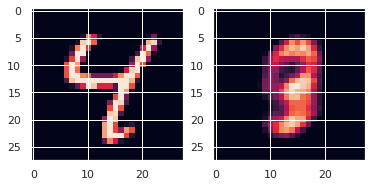

In [18]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns;sns.set()

parser = ArgumentParser(description='BetaVAE Model')
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=2)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--beta', type=float, default=10.0)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--z_features', type=int, default=64)
parser.add_argument('--mode', type=str, default='eval')
parser.add_argument('--device', type=str, default='cuda')

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

train_dataset = MNIST('./data', transform=transforms.ToTensor(), train=True, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

split = int(np.floor(args.validation_split * len(train_dataset)))
indices = list(range(len(train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders = []
mnist_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                 sampler=train_sampler)
mnist_val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                               sampler=valid_sampler)

dataloaders.append(mnist_train_loader)
dataloaders.append(mnist_val_loader)

test_dataset = MNIST('./data', transform=transforms.ToTensor(), train=False, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.encoder.add_module('reshape', Flatten())
        self.fcmu = nn.Linear(in_features= args.z_features, out_features=16)
        self.fcvar = nn.Linear(in_features = args.z_features, out_features=16)
        self.fcd = nn.Linear(in_features=16, out_features=16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fcmu(x), self.fcvar(x)

    def decode(self, z):
        z = self.decoder(z)
        return torch.sigmoid(z)

    def reparametrize(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.rand_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparametrize(mu, var)
        z = self.fcd(z)
        z = z.view(-1, 16, 1, 1)
        return self.decode(z), mu, var


model = Model()
model = model.to(DEVICE)

if args.mode == 'train':

    optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    print('training started')
    minimum_loss = float('Inf')

    training_losses = []
    rec_losses = []
    KL_losses = []
    validation_losses = []
    epochs = []

    for epoch in range(1, args.num_epochs + 1):
        epochs.append(epoch)

        for dataloader_idx, dataloader in enumerate(dataloaders):
            stage = ''

            if dataloader == mnist_train_loader:
                model.train()
                torch.set_grad_enabled(True)
            else:
                model.eval()
                torch.set_grad_enabled(False)

            epoch_loss = []
            epoch_rec_loss = []
            epoch_KL_loss = []

            for batch in dataloader:
                images, labels = batch
                images = images.to(DEVICE)

                images = images.view(images.size(0), 1, 28, 28)
                y, mu, var = model.forward(images)

                recons_loss = F.mse_loss(y, images)
                KLD = -0.5 * torch.sum(1 + torch.log(var.pow(2)) - mu.pow(2) - var.pow(2))
                loss = recons_loss + args.beta * KLD

                epoch_loss.append(loss.to('cpu').item())
                epoch_rec_loss.append(recons_loss.to('cpu').item())
                epoch_KL_loss.append(KLD.to('cpu').item())

                if dataloader == mnist_train_loader:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            if dataloader == mnist_train_loader:
                training_losses.append(np.mean(epoch_loss))
                rec_losses.append(np.mean(epoch_rec_loss))
                KL_losses.append(np.mean(epoch_KL_loss))
                stage = 'train'
            else:
                validation_losses.append(np.mean(epoch_loss))
                stage = 'eval'

            if dataloader == mnist_train_loader:
                print(
                    f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)} rec: {np.mean(epoch_rec_loss)} KL: {np.mean(epoch_KL_loss)}')
            else:
                print(f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)}')

            if dataloader_idx == 1:
                if minimum_loss > np.mean(validation_losses):
                    minimum_loss = np.mean(validation_losses)
                    torch.save(model, 'vae_best.pt')
                    model = model.to('cuda')
                    print('Model is saving')

    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.plot(epochs, rec_losses, label="REC")
    plt.plot(epochs, KL_losses, label="KL")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training , validation loss')
    plt.legend()
    plt.show()

if args.mode == 'eval':
    model = torch.load('vae_best.pt')
    model = model.to(DEVICE)
    model.eval()
    torch.set_grad_enabled(False)


    def splot(img1, img2):
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(transforms.ToPILImage()(img1))
        axarr[1].imshow(transforms.ToPILImage()(img2))
        plt.show()


    with torch.no_grad():
        test_image1 = next(iter(test_dataloader))[0][6]


        test_image = test_image1.view(1, 1, 28, 28)
        test_image = test_image.to(DEVICE)
        model_img, mu, var = model(test_image)

        model_img = model_img.cpu().squeeze(0)

        splot(test_image1, model_img)








